In [1]:
from contextlib import closing
import os
import platform
import socket
import subprocess
from subprocess import PIPE
import tempfile
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from py4j.java_gateway import JavaGateway, GatewayParameters
from py4j.java_collections import ListConverter

In [2]:
__ERODE_JAR__ = "erodeMetrics.jar"#os.path.join(os.path.dirname(__file__), "erodeMetrics.jar")
def _start_server():
    # find a free port
    for port in range(25333, 65545):
        with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
            dest_addr = ("127.0.0.1", port)
            if s.connect_ex(dest_addr):
                break

    #ld_path = __ERODE_LIB_DIR__
    #java="java"
    java ="/Library/Java/JavaVirtualMachines/jdk-11.0.14.jdk/Contents/Home/bin/java"
    argv = [java, #f'-Djava.library.path="{ld_path}"',
                "-jar", __ERODE_JAR__, str(port)]

    if platform.system() == "Linux":
        env_ld_path = os.getenv("LD_LIBRARY_PATH")
        if env_ld_path:
            ld_path = f"{ld_path}:{env_ld_path}"
        env ={"LD_LIBRARY_PATH": ld_path}
        proc = subprocess.Popen(" ".join(argv), stdout=PIPE,
                shell=True, env=env)
    else:
        proc = subprocess.Popen(argv, stdout=PIPE)
    proc.stdout.readline()
    time.sleep(2) # Sleep for 1 second
    return proc, port

def _stop_server(proc):
    print('Terminating JVM and ERODE')
    time.sleep(1) # Sleep for 1 second
    proc.terminate()
    try:
        proc.wait(5)
    except subprocess.TimeoutExpired:
        proc.kill()
        proc.wait()
    print(' Completed')

def start_JVM():
    print('Starting the JVM and ERODE')
    _proc, _port = _start_server()
    gw_params = GatewayParameters(port=_port)#, auto_convert=True)
    _gw = JavaGateway(gateway_parameters=gw_params)
    erode = _gw.entry_point
    #print(_proc)
    #_port
    print('  Completed')
    return erode,_proc,_port
        
def j_to_py_matrix(metrics_java):
    metrics_python= [ list(line) for line in metrics_java ]
    return metrics_python        

In [3]:
def loadERODESparseMatrix(AmatrixFile):
    Asparse=pd.read_csv(AmatrixFile)
    Asparse.columns=["row","column","A_{r,c}"]
    Asparse0=Asparse-1
    Asparse0["A_{r,c}"]=Asparse["A_{r,c}"]
    return Asparse0
#Asparse=loadERODESparseMatrix("test2.csv")
#Asparse

def loadERODEB(BFile):
    #pd.read_csv("test2B.csv")
    B=pd.read_csv(BFile,header=None)
    return B
#B=loadERODEB("test2B.csv")
#B

def visualizeSystem(Afile,Bfile):
    Asparse=loadERODESparseMatrix(Afile)
    B=loadERODEB(Bfile)
    
    print('Computing metrics on following Ax=B system')
    print('A (in sparse format)')
    print(Asparse.to_string(index=False))
    print('\nB')
    print(B.to_string(header=False))
    print()

#_port=100    
    
def _computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions):
    print('Loading the model in ERODE')
    if filename1.endswith('.csv'):
        erode.importAffine(filename1,filename2)
    else :
        erode.importPRISMDTMC(filename1,filename2)
    
    nVars=erode.getVariablesNum()

    if printModel:
        modelString=erode.getModelString()
        print(modelString)

    print('Computing the BB partition')
    obtained = erode.computeBB();
    if printPartitions:
        print(erode.getPartitionString(obtained))
    else:
        nBlocks=len(set(obtained))
        print('We obtained',nBlocks,'blocks out of',len(obtained),"variables")

    print('Computing the metrics')
    interestingValue=False
    metrics = erode.computeMetrics(obtained, my_lambda);
    for r in range(nVars):
        for c in range(nVars):
            print(metrics[r][c],end=" ")
            if metrics[r][c] > 0 and metrics[r][c] < 1:
                interestingValue=True
        print()
    if interestingValue:
        print('INTERESTING VALUE in (0,1)!!!!!!!!')
        print()
        
    #_stop_server(_proc)
    return metrics
    
def computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions,annotateHeatMap):
    if filename1.endswith(".csv") and printModel:
        visualizeSystem(filename1,filename2)
    metrics=_computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions)
    py_metrics=j_to_py_matrix(metrics)
    #_stop_server(_proc)
    sns.heatmap(py_metrics,annot=annotateHeatMap,linewidths=.5,cbar=False)
    plt.savefig(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+".pdf")
    return py_metrics
#_stop_server(_proc)

In [4]:
def computeMetrics_handleJVM(filename,fileName2,my_lambda,printModel,printPartitions,annotateHeatMap):
    erode,_proc,_port = start_JVM()
    py_metrics = computeMetrics(filename,fileName2,erode,_proc,_port,my_lambda,printModel,printPartitions,annotateHeatMap);
    _stop_server(_proc)


## Test Matrices

In [5]:
%time printModel=False

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 4 blocks out of 4 variables
Computing the metrics
0.0 3.0 6.0 4.0 
3.0 0.0 3.0 1.0 
6.0 3.0 0.0 2.0 
4.0 1.0 2.0 0.0 
Terminating JVM and ERODE
 Completed


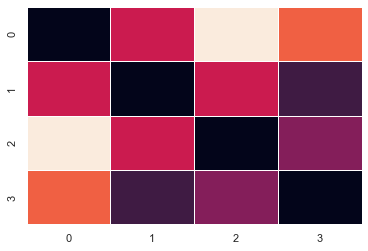

In [6]:
%time printModel=False
printPartitions=False
annotateHeatMap=False
computeMetrics_handleJVM('test.csv','testB.csv',1.0,printModel,printPartitions,annotateHeatMap)

## DTMCs

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 2 blocks out of 8 variables
Computing the metrics
0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 
Terminating JVM and ERODE
 Completed
CPU times: user 167 ms, sys: 231 ms, total: 398 ms
Wall time: 6.45 s


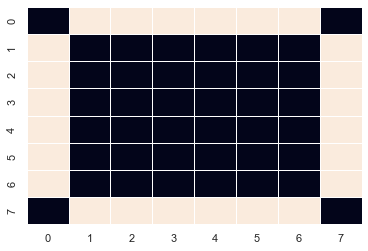

In [7]:
printModel=False
printPartitions=False
annotateHeatMap=False
%time computeMetrics_handleJVM('prismdtmc/hermann3.tra','prismdtmc/hermann3.lab',1.0,printModel,printPartitions,annotateHeatMap)

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 4 blocks out of 32 variables
Computing the metrics
0.0 0.5 0.5 0.75 0.5 1.75 0.75 0.75 0.5 1.75 1.75 1.75 0.75 1.75 0.75 0.5 0.5 0.75 1.75 0.75 1.75 1.75 1.75 0.5 0.75 0.75 1.75 0.5 0.75 0.5 0.5 0.0 
0.5 0.0 0.0 0.25 0.0 1.25 0.25 0.25 0.0 1.25 1.25 1.25 0.25 1.25 0.25 0.0 0.0 0.25 1.25 0.25 1.25 1.25 1.25 0.0 0.25 0.25 1.25 0.0 0.25 0.0 0.0 0.5 
0.5 0.0 0.0 0.25 0.0 1.25 0.25 0.25 0.0 1.25 1.25 1.25 0.25 1.25 0.25 0.0 0.0 0.25 1.25 0.25 1.25 1.25 1.25 0.0 0.25 0.25 1.25 0.0 0.25 0.0 0.0 0.5 
0.75 0.25 0.25 0.0 0.25 1.0625 0.0 0.0 0.25 1.0625 1.0625 1.0625 0.0 1.0625 0.0 0.25 0.25 0.0 1.0625 0.0 1.0625 1.0625 1.0625 0.25 0.0 0.0 1.0625 0.25 0.0 0.25 0.25 0.75 
0.5 0.0 0.0 0.25 0.0 1.25 0.25 0.25 0.0 1.25 1.25 1.25 0.25 1.25 0.25 0.0 0.0 0.25 1.25 0.25 1.25 1.25 1.25 0.0 0.25 0.25 1.25 0.0 0.25 0.0 0.0 0.5 
1.75 1.25 1.25 1.0625 1.25 0.0 1.0625 1.0625 1.25 0.0 0.0 0.0 1.0625 0.0 1.06

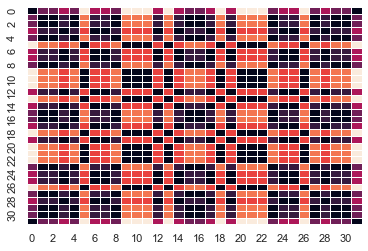

In [8]:
#"ciao".endswith('o')
#computeMetrics_handleJVM('prismdtmc/hermann3_simple.tra','prismdtmc/hermann3_simple.lab')
#computeMetrics_handleJVM('prismdtmc/hermann3.tra','prismdtmc/hermann3.lab')
#computeMetrics_handleJVM('test2.csv','test2B.csv')

%time computeMetrics_handleJVM('prismdtmc/hermann5.tra','prismdtmc/hermann5.lab',1.0,printModel,printPartitions,annotateHeatMap)
#computeMetrics_handleJVM('test.csv','testB.csv')

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 5 blocks out of 26 variables
Computing the metrics
0.0 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 5.0 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125

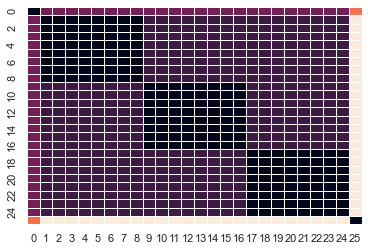

In [9]:
%time computeMetrics_handleJVM('prismdtmc/leader_sync3_2.tra','prismdtmc/leader_sync3_2.lab',1.0,printModel,printPartitions,annotateHeatMap)



Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 11 blocks out of 11 variables
Computing the metrics
0.0 1.1375 1.275 1.55 2.1 3.66875 1.9 1.45 1.225 1.1125 2.0125 
1.1375 0.0 0.275 0.55 1.1 3.5 0.9 0.45 0.225 0.025 1.1375 
1.275 0.275 0.0 0.55 1.1 3.5 0.9 0.45 0.05 0.275 1.275 
1.55 0.55 0.55 0.0 1.1 3.5 0.9 0.1 0.55 0.55 1.55 
2.1 1.1 1.1 1.1 0.0 4.6 0.2 1.1 1.1 1.1 2.1 
3.66875 3.5 3.5 3.5 4.6 0.0 4.4 3.5 3.5 3.5 3.68125 
1.9 0.9 0.9 0.9 0.2 4.4 0.0 0.9 0.9 0.9 1.9 
1.45 0.45 0.45 0.1 1.1 3.5 0.9 0.0 0.45 0.45 1.45 
1.225 0.225 0.05 0.55 1.1 3.5 0.9 0.45 0.0 0.225 1.225 
1.1125 0.025 0.275 0.55 1.1 3.5 0.9 0.45 0.225 0.0 1.1125 
2.0125 1.1375 1.275 1.55 2.1 3.68125 1.9 1.45 1.225 1.1125 0.0 
INTERESTING VALUE in (0,1)!!!!!!!!

Terminating JVM and ERODE
 Completed
CPU times: user 192 ms, sys: 333 ms, total: 525 ms
Wall time: 6.93 s


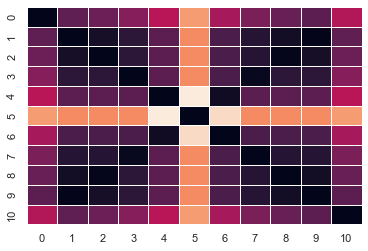

In [10]:
%time computeMetrics_handleJVM('prismdtmc/haddad-monmege.v1n5p0.6.tra','prismdtmc/haddad-monmege.v1nn5p0.6.lab',1.0,printModel,printPartitions,False)


Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 39 blocks out of 57 variables
Computing the metrics
0.0 5.00463 4.01389 4.01389 0.00463 3.01389 3.02778 0.01389 3.01389 0.01389 0.00463 2.01389 2.02778 0.01389 2.02778 0.02778 0.01389 2.01389 0.01389 0.01389 0.00463 1.01389 1.02778 0.01389 1.02778 0.02778 0.01389 1.02778 0.02778 0.02778 0.01389 1.01389 0.01389 0.01389 0.01389 0.00463 0.11389 0.12778 1.01389 0.12778 1.02778 1.01389 0.12778 1.02778 1.02778 1.01389 0.12778 1.02778 1.02778 1.02778 1.01389 1.64389 1.91389 0.29389 1.91389 1.91389 2.89463 
5.00463 0.0 2.03699 2.92866 5.0 3.01856 3.0464 4.99078 3.91856 4.99078 5.0 4.0093 4.02326 4.99078 4.02326 4.97696 4.99078 3.2893 4.99078 4.99078 5.0 5.00004 5.00011 4.99078 5.00011 4.97696 4.99078 5.00011 4.97696 4.97696 4.99078 5.90004 4.99078 4.99078 4.99078 5.0 5.09078 5.07696 5.99078 5.07696 5.97696 5.99078 4.97927 5.00011 5.00011 5.00004 4.88927 4.10011 4.10011 4.10011 5.63004 6.620

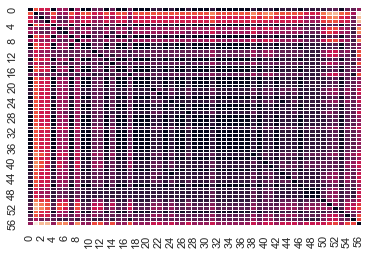

In [11]:
%time computeMetrics_handleJVM('prismdtmc/oscillatorsmu0.1.lambda1.tra','prismdtmc/oscillatorsmu0.1.lambda1.lab',1.0,printModel,printPartitions,False)


Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 62 blocks out of 62 variables
Computing the metrics
0.0 2.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 0.98 0.02 1.0 1.0 1.0 0.99 0.01 1.0 1.0 1.96 0.04 0.99 0.01 0.98 0.02 1.0 1.0 1.0 1.0 1.98 0.02 0.98 0.02 1.0 1.0 1.0 0.98 0.02 1.98 0.02 0.98 0.02 1.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 
2.0 0.0 3.0004 3.0004 2.0008 3.01901 3.9408 2.0 1.99921 2.94079 2.0 2.0 2.0 1.0396 2.0 1.9608 1.9996 2.96978 2.96039 2.9796 2.0196 2.95059 2.0096 1.98079 1.99961 2.0 1.02039 2.0 2.0 2.0288 1.99 1.99999 2.0 2.00038 2.00019 1.0592 2.00038 2.00001 1.10741 1.9904 2.00019 2.0 2.0 2.0 2.01938 2.0096 2.0 2.99 2.00001 2.9904 2.0 2.9504 2.98 2.10741 1.98001 2.9804 1.9808 2.9804 2.0 3.0 2.0 2.99999 
2.0 3.0004 0.0 2.01059 3.0008 3.99 4.0 2.0 2.98 3.0 2.0 2.0 2.98 2.0196 3.0 2.9506 2.0096 3.0 3.0 3.96 2.04 2.99 2.01 2.00039 2.00001 2.98 2.0002 2.98 3.0 2.9995 2.0097 2.0097 2.000

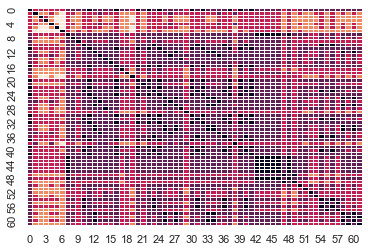

In [12]:
%time computeMetrics_handleJVM('prismdtmc/brpN2.MAX1.tra','prismdtmc/brpN2.MAX1.lab',1.0,printModel,printPartitions,False)

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 20 blocks out of 20 variables
Computing the metrics
0.0 2.0 1.0 0.98 0.02 1.0 2.0 0.98 0.02 1.0 2.0 0.98 0.02 1.0 2.0 1.0 1.0 1.0 1.0 1.0 
2.0 0.0 2.0 2.0 2.0 2.0 2.0396 1.98079 1.99961 2.0 2.02039 1.98041 1.9996 2.0 2.02001 2.0 2.0 2.0 1.98 2.0 
1.0 2.0 0.0 1.0 1.0 0.98 2.0 1.0 1.0 0.98 2.0 1.0 1.0 0.98 2.0 0.02 0.02 0.02 1.0 1.0 
0.98 2.0 1.0 0.0 0.96 1.0 1.9804 0.0196 0.9604 1.0 1.9804 0.0196 0.9604 1.0 1.9804 1.0 1.0 1.0 0.0396 1.0 
0.02 2.0 1.0 0.96 0.0 1.0 1.9996 0.9604 0.0004 1.0 1.9996 0.9604 0.0004 1.0 1.9996 1.0 1.0 1.0 0.9804 1.0 
1.0 2.0 0.98 1.0 1.0 0.0 2.0 1.0 1.0 0.0196 2.0 1.0 1.0 0.0196 2.0 0.96 0.9604 0.9604 1.0 0.0396 
2.0 2.0396 2.0 1.9804 1.9996 2.0 0.0 1.9608 1.9992 2.0 2.0196 1.96119 1.99921 2.0 2.0196 2.0 2.0 2.0 1.9604 2.0 
0.98 1.98079 1.0 0.0196 0.9604 1.0 1.9608 0.0 0.96 1.0 1.96119 0.00039 0.96001 1.0 1.96119 1.0 1.0 1.0 0.02039 1.0 
0.02 1.99961 1.0 0.9

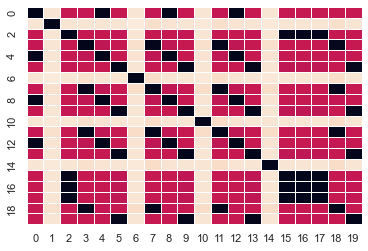

In [13]:
%time computeMetrics_handleJVM('prismdtmc/brpN1.MAX2.tra','prismdtmc/brpN1.MAX2.lab',1.0,printModel,printPartitions,False)

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 44 blocks out of 44 variables
Computing the metrics
0.0 1.0 0.1 0.9 0.1 0.9 0.1 0.9 1.04 2.96 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
1.0 0.0 1.0 1.0 0.91 0.19 0.99 0.91 0.908 2.06 1.04 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.1 1.0 0.0 0.8 0.1 0.9 0.1 0.9 1.0166 2.879 0.9908 1.1 1.004 1.1 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.9 1.0 0.8 0.0 0.9 0.9 0.9 0.9 0.9446 2.231 0.9172 1.9 1.036 1.9 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.1 0.91 0.1 0.9 0.0 0.8 0.08 0.88 0.998 2.87 1.00166 1.1 0.99908 1.01 1.0004 1.01 1.0 1.0 1.0 1.0 1.0 1.

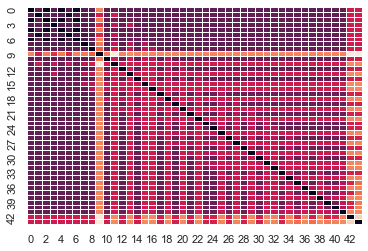

In [14]:
%time computeMetrics_handleJVM('prismdtmc/nandN1.K2.tra','prismdtmc/nandN1.K2.lab',1.0,printModel,printPartitions,False)

## Weighted Networks



HANDLING  dom_DeLaFuente_2019A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 339.0 292.0 309.0 260.0 368.0 
339.0 0.0 141.0 88.0 207.0 103.0 
292.0 141.0 0.0 155.0 196.0 170.0 
309.0 88.0 155.0 0.0 219.0 151.0 
260.0 207.0 196.0 219.0 0.0 132.0 
368.0 103.0 170.0 151.0 132.0 0.0 
Terminating JVM and ERODE
 Completed
CPU times: user 168 ms, sys: 338 ms, total: 506 ms
Wall time: 6.5 s


HANDLING  moviegalaxies_765A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 14 blocks out of 15 variables
Computing the metrics
0.0 3.0 74.0 65.0 23.0 6.0 4.0 60.0 10.0 4.0 84.0 4.0 3.0 51.0 3.0 
3.0 0.0 73.0 62.0 20.0 3.0 3.0 57.0 11.0 3.0 83.0 5.0 4.0 50.0 4.0 
74.0 73.0 0.0 61.0 73.0 72.0 76.0 52.0 64.0 72.0 66.0 74.0 75.0 53.0 75.0 
65.0 62.0 61.0 0.0 44.0 59.0 63.0 33.0 59.0 63.0 67.0 63.0 64.0 40.0 64.0 
23.0 20.0 73.0 44

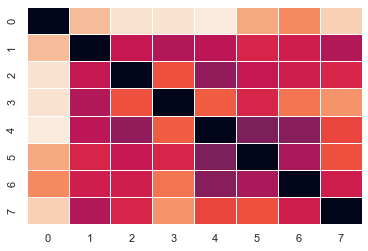

In [15]:
import os
files = os.listdir('weightedGraphs/csv/')
for f in files:
    if f.endswith('A.csv'):
        print()
        print()
        print("HANDLING ",f)
        AFile = 'weightedGraphs/csv/'+f
        BFile = 'weightedGraphs/csv/'+f.replace('A.csv','B.csv')
        %time computeMetrics_handleJVM(AFile,BFile,1.0,printModel,printPartitions,False)
#computeMetrics_handleJVM('weightedGraphs/csv/moviegalaxies_814A.csv','weightedGraphs/csv/moviegalaxies_814B.csv',1.0)

## Trash

In [16]:
py_metrics

NameError: name 'py_metrics' is not defined

In [ ]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax = sns.heatmap(py_metrics,annot=True,linewidths=.5)
plt.savefig('save_as_a_pdf.pdf')

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(py_metrics, cmap='hot', interpolation='nearest')
# plt.show()

In [ ]:
#%pip install seaborn